# Updated Baseline
The code and results below correspond to an upgraded baseline upon the Landslide4Sense dataset. The actual baseline suggested by the dataset was 56% in F1 and 76% in MLou. Here, I replicated the baseline and added my own touches to see how it affects our results.

## Initial Setup and Tests
General focus here is to just get a feel of the data, its dimensions and how we can use for eventual training. Below are cells that:


*   Mount our drive (where the data is located) and initalizes paths.
*   pip install and import all required packages for our baseline.



In [ ]:
# install and configure
!pip install --quiet kaggle
from google.colab import files
files.upload()                         # upload kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download tekbahadurkshetri/landslide4sense \
-p /content/landslide_data --unzip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/tekbahadurkshetri/landslide4sense
License(s): other
 97% 2.76G/2.85G [00:05<00:00, 320MB/s]
100% 2.85G/2.85G [00:05<00:00, 519MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_PATH = "/content"
DATA_PATH = f"{BASE_PATH}/landslide_data"
DRIVE_PATH = f"{BASE_PATH}/drive/MyDrive/LandslideDetection"
Model_One =  f"{DRIVE_PATH}/Ensemble_Models/DeepLabV3_CombinedLoss_Model.pth"
Model_Two =  f"{DRIVE_PATH}/Ensemble_Models/Resnet_UNet_BestSegF1_SpecificThresholds"

In [ ]:
!pip install pandas numpy torch torchvision torchaudio h5py -q
!pip install opencv-python matplotlib segmentation-models-pytorch albumentations tqdm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.9 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
import os
import cv2
import matplotlib as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import h5py

## Data and loading Dataset class
This Section focuses on initializing our .h5 image data. I went through several resources to understand this datatype.

In [ ]:
# Test Data and check type, verified it here.

sample_path = f"{DATA_PATH}/TrainData/img/image_1.h5"  # adjust this to match one of your file names

with h5py.File(sample_path, 'r') as f:
    print(list(f.keys()))  # shows all datasets inside the file
    data = f['img'][:]   # try reading the image data (dataset name might be different, we’ll check)
    print("Data shape:", data.shape)

mask_path = f"{DATA_PATH}/TrainData/mask/mask_1.h5"

with h5py.File(mask_path, 'r') as f:
    print(f.keys())  # find correct key
    mask = f['mask'][:]  # or whatever the key is
    print("Mask shape:", mask.shape)
    print("Unique values:", np.unique(mask))


['img']
Data shape: (128, 128, 14)
<KeysViewHDF5 ['mask']>
Mask shape: (128, 128)
Unique values: [0 1]


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 1) Band‑engineering function
def compute_26_bands(raw):
    """
    raw: np.ndarray of shape (14, H, W)
    returns: np.ndarray of shape (26, H, W)
    """
    B2, B3, B4 = raw[1], raw[2], raw[3]
    B8, B11, B12 = raw[7], raw[10], raw[11]

    # Normalize B2, B3, B4
    def norm(b): return (b - b.min())/(b.max() - b.min() + 1e-8)
    B2n, B3n, B4n = norm(B2), norm(B3), norm(B4)

    # Spectral indices
    ndvi = (B8 - B4) / (B8 + B4 + 1e-8)
    ndmi = (B8 - B11) / (B8 + B11 + 1e-8)
    nbr  = (B8 - B12) / (B8 + B12 + 1e-8)

    # Grayscale
    gray = (B2 + B3 + B4) / 3.0

    # Smoothing (odd kernels)
    gauss  = cv2.GaussianBlur(gray,  (11, 11), 0)
    median = cv2.medianBlur((gray*255).astype(np.uint8), 11) / 255.0

    # Gradients
    gradx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    grady = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    # Edge map
    canny = cv2.Canny((gray*255).astype(np.uint8), 100, 200) / 255.0

    # Stack extras as (1, H, W)
    extras = [e[np.newaxis, ...] for e in [
        B2n, B3n, B4n,
        ndvi, ndmi, nbr,
        gray, gauss, median,
        gradx, grady, canny
    ]]

    return np.concatenate([raw] + extras, axis=0)


# 2) Dataset class
class LandSlideHSDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform=None):
        self.img_paths  = img_paths
        self.mask_paths = mask_paths
        self.transform  = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Load raw 14-band image (H, W, 14)
        with h5py.File(self.img_paths[idx], 'r') as f:
            raw14 = f['img'][:]             # NumPy (H, W, 14)

        # Compute 26 bands
        raw14_chw = np.transpose(raw14, (2, 0, 1))  # (14, H, W)
        full26_chw = compute_26_bands(raw14_chw)[:23]    # (26, H, W)
        img = np.transpose(full26_chw, (1, 2, 0))   # (H, W, 26)

        # Load mask (H, W)
        with h5py.File(self.mask_paths[idx], 'r') as f:
            mask = f['mask'][:]                   # NumPy (H, W)

        # Apply Albumentations transforms
        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img, mask = aug['image'], aug['mask']

        # img is now Tensor (C=26, H, W); mask is Tensor (H, W)
        img_tensor  = img.float()
        mask_tensor = mask.unsqueeze(0).float()     # add channel dim → (1, H, W)

        return img_tensor, mask_tensor


# 3) Define transforms
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2(),
])

# 4) Instantiate & test
DATA_PATH = f"{BASE_PATH}/landslide_data"
ds = LandSlideHSDataset(
    img_paths=[
        f"{DATA_PATH}/TrainData/img/image_1.h5",
        f"{DATA_PATH}/TrainData/img/image_2.h5",
    ],
    mask_paths=[
        f"{DATA_PATH}/TrainData/mask/mask_1.h5",
        f"{DATA_PATH}/TrainData/mask/mask_2.h5",
    ],
    transform=train_transform
)
print("Dataset length:", len(ds))
img_tensor, mask_tensor = ds[0]
print("Image tensor shape:", img_tensor.shape)  # expect (26, 128, 128)
print("Mask tensor shape: ", mask_tensor.shape) # expect (1, 128, 128)

Dataset length: 2
Image tensor shape: torch.Size([23, 256, 256])
Mask tensor shape:  torch.Size([1, 256, 256])


In [ ]:
# Use Dataloaders and split the Training data into a 80/20 Split.

img_dir  = f"{DATA_PATH}/TrainData/img"
mask_dir = f"{DATA_PATH}/TrainData/mask"

all_img_paths = sorted([
    os.path.join(img_dir,  fname)
    for fname in os.listdir(img_dir)
    if fname.endswith('.h5')
])

all_mask_paths = sorted([
    os.path.join(mask_dir, fname)
    for fname in os.listdir(mask_dir)
    if fname.endswith('.h5')
])

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# This will shuffle and split in one go:
img_train, img_val, mask_train, mask_val = train_test_split(
    all_img_paths, all_mask_paths,
    test_size=0.2,      # 20% validation
    random_state=42     # fixed seed for reproducibility
)

train_ds = LandSlideHSDataset(img_train, mask_train, transform=train_transform)
val_ds   = LandSlideHSDataset(img_val,   mask_val, transform=val_transform)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2)

# Check lengths & shapes
print(len(train_loader), len(val_loader))
imgs, msks = next(iter(train_loader))
print(imgs.shape, msks.shape)

380 95
torch.Size([8, 23, 256, 256]) torch.Size([8, 1, 256, 256])


## Model Initialization

i initialize and set up the loss, network and optimizer here.

Disagreement Matrix: 100%|██████████| 95/95 [00:12<00:00,  7.78it/s]


📊 Model Disagreement Matrix:
Both predicted 1   : 2.06%
Both predicted 0   : 97.26%
Model 1 = 1, Model 2 = 0 : 0.16%
Model 1 = 0, Model 2 = 1 : 0.52%
Total Disagreement : 0.68%


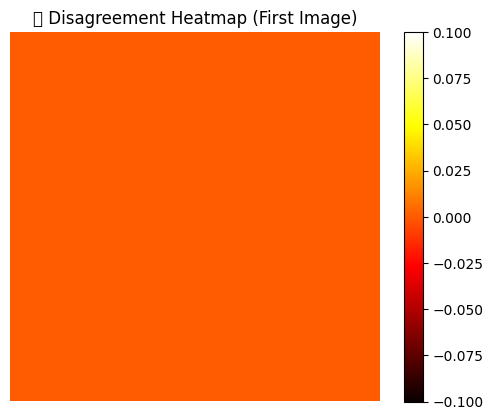

In [ ]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Define models with 23 input channels
def make_deeplab():
    return smp.DeepLabV3Plus(
        encoder_name='mit_b1',
        encoder_weights='imagenet',
        in_channels=23,
        classes=1,
        activation=None
    ).to(device)

def make_unet():
    return smp.UnetPlusPlus(
        encoder_name='resnet34',
        in_channels=23,
        classes=1,
        activation=None
    ).to(device)

# 2. Load models
model1 = make_deeplab()
model1.load_state_dict(torch.load(Model_One, map_location=device))
model1.eval()

model2 = make_unet()
model2.load_state_dict(torch.load(Model_Two, map_location=device))
model2.eval()

# 3. Disagreement stats
both_1 = both_0 = a1_b0 = a0_b1 = 0
total_pixels = 0

with torch.no_grad():
    for imgs, _ in tqdm(val_loader, desc="Disagreement Matrix"):
        imgs = imgs.to(device)

        probs1 = torch.sigmoid(model1(imgs))
        probs2 = torch.sigmoid(model2(imgs))
        preds1 = (probs1 > 0.5).int()
        preds2 = (probs2 > 0.5).int()

        both_1 += ((preds1 == 1) & (preds2 == 1)).sum().item()
        both_0 += ((preds1 == 0) & (preds2 == 0)).sum().item()
        a1_b0  += ((preds1 == 1) & (preds2 == 0)).sum().item()
        a0_b1  += ((preds1 == 0) & (preds2 == 1)).sum().item()
        total_pixels += preds1.numel()

# 4. Output matrix
print("\n📊 Model Disagreement Matrix:")
print(f"Both predicted 1   : {both_1/total_pixels:.2%}")
print(f"Both predicted 0   : {both_0/total_pixels:.2%}")
print(f"Model 1 = 1, Model 2 = 0 : {a1_b0/total_pixels:.2%}")
print(f"Model 1 = 0, Model 2 = 1 : {a0_b1/total_pixels:.2%}")
print(f"Total Disagreement : {(a1_b0 + a0_b1)/total_pixels:.2%}")

# 5. Visualize disagreement (on first batch only)
for imgs, _ in val_loader:
    imgs = imgs.to(device)
    with torch.no_grad():
        probs1 = torch.sigmoid(model1(imgs))
        probs2 = torch.sigmoid(model2(imgs))
        preds1 = (probs1 > 0.5).int()
        preds2 = (probs2 > 0.5).int()

    diff_mask = (preds1[0] != preds2[0]).cpu()
    plt.imshow(diff_mask.squeeze(), cmap='hot')
    plt.title("🔥 Disagreement Heatmap (First Image)")
    plt.colorbar()
    plt.axis('off')
    plt.show()
    break

## Development Loop
a step i deemed exceptionally important. This is to basically check if the actual logic is working before committing resources and time to a full train. This only trains and maps 3 epochs.

In [25]:
model1.eval()
model2.eval()

from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, masks in tqdm(val_loader, desc="Evaluating Ensemble"):
        imgs = imgs.to(device)
        masks = masks.to(device)

        # 1. Get probabilities from both models
        probs1 = torch.sigmoid(model1(imgs))
        probs2 = torch.sigmoid(model2(imgs))

        # 2. Average the probs (Soft Voting)
        ensemble_probs = (0.25 * probs1 + 0.75 * probs2)

        # 3. Threshold
        preds = (ensemble_probs > 0.5).float()

        # 4. Collect results
        all_preds.extend(preds.cpu().numpy().flatten())
        all_labels.extend(masks.cpu().numpy().flatten())

# 5. Compute scores
f1 = f1_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)

print(f" Ensemble F1: {f1:.4f}")
print(f" Precision: {prec:.4f}")
print(f" Recall: {rec:.4f}")


Evaluating Ensemble: 100%|██████████| 95/95 [00:12<00:00,  7.33it/s]


 Ensemble F1: 0.7674
 Precision: 0.7679
 Recall: 0.7669


## Actual Training Loop
This is the main training loop where the whole training takes place. 20 epochs trained and models are saved at checkpoints (in case of interruptions).
The code is designed to be fail-safe and tells us the results we need at the end of this execution.

[E01] train=0.8724, val=0.6788, f1=0.6145, prec=0.6920, rec=0.5526  (76.3s)


[E02] train=0.6296, val=0.5898, f1=0.5616, prec=0.8679, rec=0.4151  (74.5s)


[E03] train=0.5731, val=0.5558, f1=0.6331, prec=0.8348, rec=0.5099  (75.5s)


[E04] train=0.5478, val=0.5388, f1=0.6625, prec=0.8515, rec=0.5421  (75.6s)


[E05] train=0.5374, val=0.5315, f1=0.7047, prec=0.7011, rec=0.7084  (75.7s)


[E06] train=0.5300, val=0.5255, f1=0.6959, prec=0.8312, rec=0.5984  (75.7s)


[E07] train=0.5258, val=0.5212, f1=0.7222, prec=0.8226, rec=0.6437  (76.0s)


[E08] train=0.5230, val=0.5216, f1=0.7047, prec=0.8024, rec=0.6281  (75.8s)


[E09] train=0.5209, val=0.5257, f1=0.7120, prec=0.6390, rec=0.8038  (76.0s)


[E10] train=0.5159, val=0.5178, f1=0.7355, prec=0.8163, rec=0.6693  (75.8s)


[E11] train=0.5177, val=0.5169, f1=0.7359, prec=0.8041, rec=0.6784  (75.9s)


[E12] train=0.5165, val=0.5154, f1=0.7358, prec=0.8232, rec=0.6651  (75.9s)


[E13] train=0.5161, val=0.5160, f1=0.7273, prec=0.8229, rec=0.6517  (76.0s)


[E14] train=0.5147, val=0.5147, f1=0.7393, prec=0.8151, rec=0.6764  (76.0s)


[E15] train=0.5133, val=0.5149, f1=0.7416, prec=0.8361, rec=0.6662  (76.0s)


[E16] train=0.5126, val=0.5146, f1=0.7502, prec=0.7902, rec=0.7141  (76.1s)


[E17] train=0.5101, val=0.5147, f1=0.7577, prec=0.7505, rec=0.7650  (75.9s)


[E18] train=0.5089, val=0.5170, f1=0.7307, prec=0.7498, rec=0.7124  (76.0s)


[E19] train=0.5104, val=0.5156, f1=0.7205, prec=0.8397, rec=0.6309  (77.1s)


[E20] train=0.5085, val=0.5143, f1=0.7547, prec=0.7831, rec=0.7283  (75.9s)


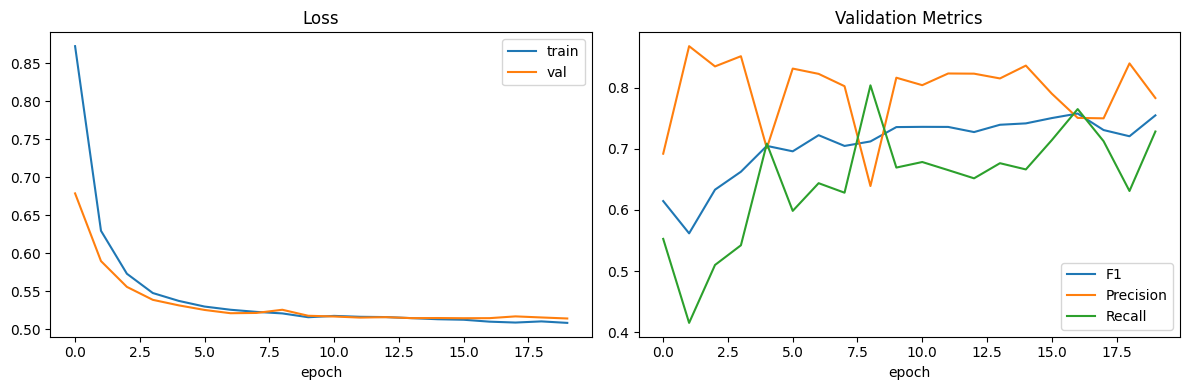

In [ ]:
import time
import numpy as np
import torch
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# ─── A) CONFIG ────────────────────────────────────────────────
NUM_EPOCHS = 20

train_losses = []
val_losses = []
val_f1s, val_precs, val_recs = [], [], []
best_f1 = -1.0  # Initialize best F1 score

# Create outputs directory if it doesn't exist
OUTPUTS_DIR = os.path.join(BASE_PATH, "outputs") # Use BASE_PATH from the notebook
os.makedirs(OUTPUTS_DIR, exist_ok=True)

# ─── B) TRAINING LOOP ─────────────────────────────────────────
for epoch in range(1, NUM_EPOCHS+1):
    start = time.time()

    # --- TRAIN ---
    model.train()
    running_loss = 0.0
    for imgs, masks in tqdm(train_loader, desc=f"[E{epoch:02d}] Train", leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        optim.zero_grad()
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        loss.backward()
        optim.step()
        running_loss += loss.item() * imgs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # --- VALIDATE ---
    model.eval()
    running_loss = 0.0
    y_true, y_prob = [], []

    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"[E{epoch:02d}] Val", leave=False):
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            loss = combined_loss(logits, masks)
            running_loss += loss.item() * imgs.size(0)

            probs = torch.sigmoid(logits).cpu().numpy().ravel()
            masks = masks.cpu().numpy().ravel().astype(int)

            y_prob.append(probs)
            y_true.append(masks)

    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    y_true = np.concatenate(y_true)
    y_prob = np.concatenate(y_prob)

    # --- Threshold Sweeping for F1 Score ---
    thresholds = np.linspace(0, 1, 100)  # Sweep through 100 thresholds from 0 to 1
    best_epoch_f1 = -1.0
    best_threshold = -1.0

    for threshold in thresholds:
        y_pred = (y_prob > threshold).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_epoch_f1:
            best_epoch_f1 = f1
            best_threshold = threshold

    val_f1s.append(best_epoch_f1)

    # Calculate precision and recall at the best threshold for this epoch
    y_pred_best = (y_prob > best_threshold).astype(int)
    prec_at_best_f1 = precision_score(y_true, y_pred_best, zero_division=0)
    rec_at_best_f1 = recall_score(y_true, y_pred_best, zero_division=0)

    val_precs.append(prec_at_best_f1)
    val_recs.append(rec_at_best_f1)


    print(f"[E{epoch:02d}] train={train_loss:.4f}, val={val_loss:.4f}, "
          f"f1={best_epoch_f1:.4f} (thresh={best_threshold:.2f}), prec={prec_at_best_f1:.4f}, rec={rec_at_best_f1:.4f}  ({time.time()-start:.1f}s)")

    # Save best model based on F1 score
    if best_epoch_f1 > best_f1:
        best_f1 = best_epoch_f1
        model_save_path = os.path.join(OUTPUTS_DIR, "ResNet_CombinedLoss_Unet++.pth") # Use correct Loss function name
        torch.save(model.state_dict(), model_save_path)
        print(f"--> Saved best model with F1: {best_f1:.4f} to {model_save_path}")


plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label="train")
plt.plot(val_losses,   label="val")
plt.title("Loss")
plt.xlabel("epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_f1s,   label="F1")
plt.plot(val_precs, label="Precision")
plt.plot(val_recs,  label="Recall")
plt.title("Validation Metrics (at best threshold)")
plt.xlabel("epoch")
plt.legend()

plt.tight_layout()
plt.show()

# Task
Add threshold sweeping to the training process, save the best model based on F1 score as "ResNet_(Loss Function)_Unet++" in the parent directory's "outputs" folder, and prepare the results for presentation.

## Add threshold sweeping

### Subtask:
Modify the training loop to calculate and track the F1 score at different thresholds.


**Reasoning**:
I need to modify the validation loop to calculate and track F1 scores across a range of thresholds and identify the best F1 score and its corresponding threshold for each epoch.

